In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
init_printing()

In [2]:
x = [Symbol(f'x_{{{i}}}', real=True) for i in range(16)]
theta = [Symbol(f'\\theta_{{{i}}}', real=True) for i in range(len(x))]
b = Symbol(f'b', real=True)
Theta = theta + [b]

In [3]:
f = sum(x_*theta_ for x_,theta_ in zip(x,theta)) + b
f = tanh(f)
f

In [4]:
X = (np.random.rand(10, len(x))-0.5)*10
M = np.random.randn(len(x), 1)
Y = X @ M + np.random.randn()
Y = np.tanh(Y)

In [5]:
%%time
cost = (1/Y.shape[0])*sum([
    (f.subs({x_:x_sam_ for x_,x_sam_ in zip(x,x_sam)}) - y_sam)**2 for x_sam,y_sam in zip(X,Y)])

CPU times: user 849 ms, sys: 0 ns, total: 849 ms
Wall time: 848 ms


In [6]:
%%time
infos = [((1/Y.shape[0])*sum([
    ((f.subs({x_:x_sam_ for x_,x_sam_ in zip(x,x_sam)}) - y_sam)**2) \
    .diff(theta_)**2 for x_sam,y_sam in zip(X,Y)])) for theta_ in Theta]

CPU times: user 8.63 s, sys: 12.8 ms, total: 8.64 s
Wall time: 8.66 s


In [7]:
%%time
grads = [cost.diff(theta_) for theta_ in Theta]
curvs = [grad.diff(theta_) for grad,theta_ in zip(grads,Theta)]

CPU times: user 2.46 s, sys: 6.7 ms, total: 2.46 s
Wall time: 2.47 s


In [8]:
%%time
hess = hessian(cost, Theta)
hess = np.array([[lambdify(tuple(Theta), hess[y,x]) for x in range(len(Theta))] for y in range(len(Theta))])

CPU times: user 8min 49s, sys: 266 ms, total: 8min 49s
Wall time: 8min 50s


In [9]:
cost = lambdify(tuple(Theta), cost)
infos = np.array([lambdify(tuple(Theta), info) for info in infos])
grads = np.array([lambdify(tuple(Theta), grad) for grad in grads])
curvs = np.array([lambdify(tuple(Theta), curv) for curv in curvs])

### GD+Moment

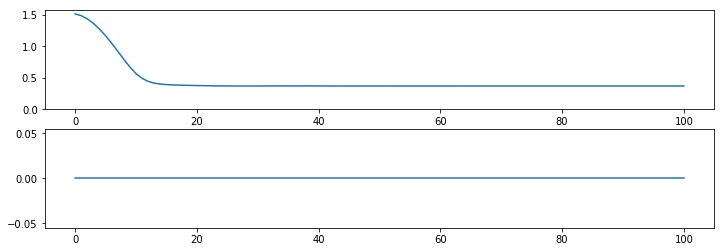

0.3679298893940035 0.00011143313350001133 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.]


In [10]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
mnt_old = 0.
beta = 0.9
for epoch in range(100):
    mnt_1 = np.zeros_like(para)
    for i in range(len(Theta)):
        mnt_1[i] = 1e-2*grads[i](*para)
    mnt_1 = beta*mnt_old + (1-beta)*mnt_1
    cost_1 = cost(*(para - mnt_1))
    cost_lowest = np.nanargmin([cost_1])
    cost_lowests.append(cost_lowest)
    mnt_old = [mnt_1][cost_lowest]
    para -= mnt_old
    cost_new = [cost_1][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### GD+Moment with cosine annealing

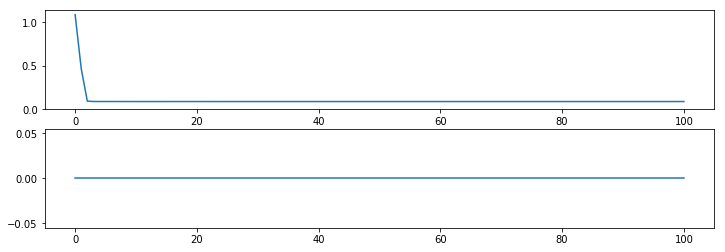

0.08794204200134519 4.041146829986656e-09 [ 1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1.]


In [11]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
mnt_old = 0.
beta = 0.9
for epoch in range(100):
    mnt_1 = np.zeros_like(para)
    alpha = (np.cos(np.log(epoch+1e-9) * 2*np.pi)+1)/2 * 3
    for i in range(len(Theta)):
        mnt_1[i] = alpha*grads[i](*para)
    mnt_1 = beta*mnt_old + (1-beta)*mnt_1
    cost_1 = cost(*(para - mnt_1))
    cost_lowest = np.nanargmin([cost_1])
    cost_lowests.append(cost_lowest)
    mnt_old = [mnt_1][cost_lowest]
    para -= mnt_old
    cost_new = [cost_1][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### per parameter newton (update at the same time) with GD

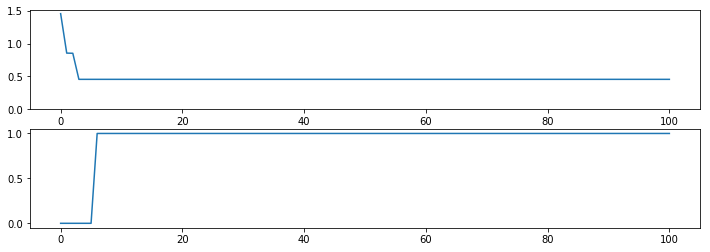

0.455265320065036 1.9883321706415094e-18 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [12]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    for i in range(len(Theta)):
        para_1[i] = para[i] - grads[i](*para)/abs(curvs[i](*para))
        para_2[i] = para[i] - 1e-2*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### per parameter newton (update at the same time) with GD+Moment

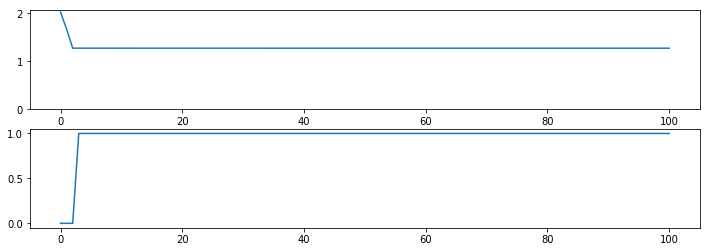

1.274781625810944 0.0001738662074382511 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
mnt_old = 0.
beta = 0.9
for epoch in range(100):
    mnt_1 = np.zeros_like(para)
    mnt_2 = np.zeros_like(para)
    for i in range(len(Theta)):
        mnt_1[i] = grads[i](*para)/abs(curvs[i](*para))
        mnt_2[i] = 1e-2*grads[i](*para)
    mnt_2 = beta*mnt_old + (1-beta)*mnt_2
    cost_1 = cost(*(para - mnt_1))
    cost_2 = cost(*(para - mnt_2))
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para -= [mnt_1,mnt_2][cost_lowest]
    mnt_old = mnt_2
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### per parameter newton (update one by one) with GD

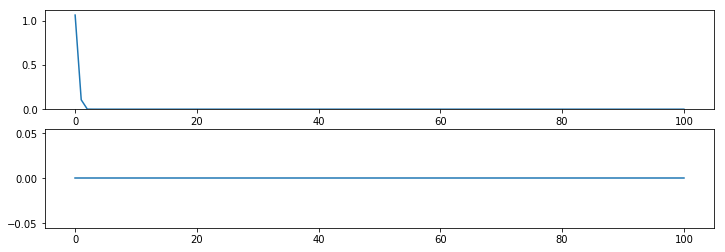

3.380394592797495e-05 6.108617522764653e-08 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [14]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    for i in range(len(Theta)):
        para_1[i] = para_1[i] - grads[i](*para_1)/abs(curvs[i](*para_1))
        para_2[i] = para[i] - 1e-2*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### per parameter newton (update one by one) with GD+Moment

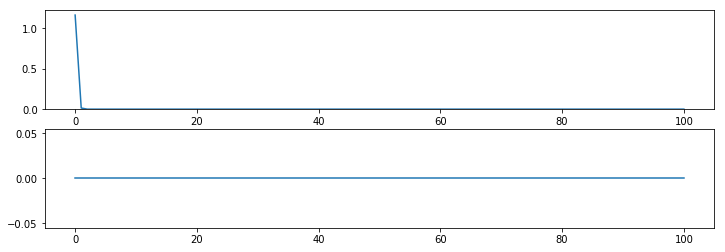

0.0006689416529536377 7.188120334076911e-09 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [15]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
mnt_old = 0.
beta = 0.9
for epoch in range(100):
    para_1 = np.copy(para)
    mnt_2 = np.zeros_like(para)
    for i in range(len(Theta)):
        para_1[i] = para_1[i] - grads[i](*para_1)/abs(curvs[i](*para_1))
        mnt_2[i] = 1e-2*grads[i](*para)
    mnt_2 = beta*mnt_old + (1-beta)*mnt_2
    cost_1 = cost(*(para_1))
    cost_2 = cost(*(para - mnt_2))
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para-mnt_2][cost_lowest]
    mnt_old = mnt_2
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### newton hessian with GD

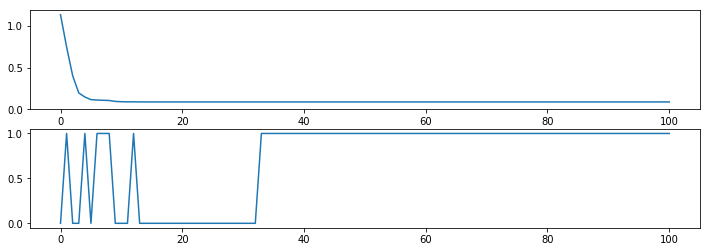

0.08725720514067443 7.675291491581833e-23 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [16]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    g = np.array([grad(*para) for grad in grads])
    try:
        hg = np.linalg.inv(np.array([[
            h(*para) for h in hy] for hy in hess])) @ g
        para_1 = para_1 - hg * np.sign(g.T @ hg)
    except:
        para_1 = np.full_like(para_1, np.nan)
    for i in range(len(Theta)):
        para_2[i] = para[i] - 1e-2*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### newton abs hessian with GD

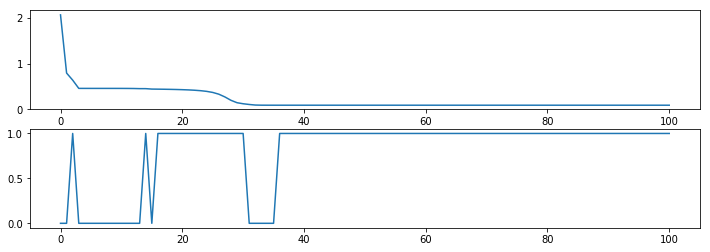

0.08733545905181922 3.1729848724884014e-05 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [17]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    g = np.array([grad(*para) for grad in grads])
    try:
        h = np.array([[h(*para) for h in hy] for hy in hess])
        h_eval,h_evec = np.linalg.eigh(h)
        h = np.linalg.inv(h_evec.T) @ np.diag(np.abs(h_eval)) @ h_evec.T
        hg = np.linalg.inv(h) @ g
        para_1 = para_1 - hg
    except:
        para_1 = np.full_like(para_1, np.nan)
    for i in range(len(Theta)):
        para_2[i] = para[i] - 1e-2*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### newton partial hessian with GD

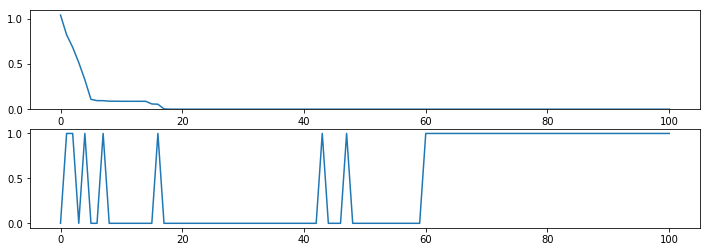

1.4443534383715222e-05 1.7311394325272438e-07 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [18]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    z = np.array(np.random.choice(range(len(Theta)), size=len(Theta)//2, replace=False))
    g = np.array([grad(*para) for grad in grads[z]])
    try:
        hg = np.linalg.inv(np.array([[
            h(*para) for h in hy[z]] for hy in hess[z]])) @ g
        para_1[z] = para_1[z] - hg * np.sign(g.T @ hg)
    except:
        para_1[z] = np.full_like(para_1[z], np.nan)
    for i in range(len(Theta)):
        para_2[i] = para[i] - 1e-2*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### newton partial abs hessian with GD

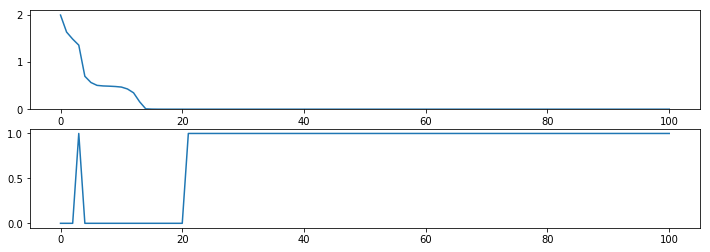

0.0001134022065620868 2.7487826856465547e-06 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [19]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    z = np.array(np.random.choice(range(len(Theta)), size=len(Theta)//2, replace=False))
    g = np.array([grad(*para) for grad in grads[z]])
    try:
        h = np.array([[h(*para) for h in hy[z]] for hy in hess[z]])
        h_eval,h_evec = np.linalg.eigh(h)
        h = np.linalg.inv(h_evec.T) @ np.diag(np.abs(h_eval)) @ h_evec.T
        hg = np.linalg.inv(h) @ g
        para_1[z] = para_1[z] - hg
    except:
        para_1[z] = np.full_like(para_1[z], np.nan)
    for i in range(len(Theta)):
        para_2[i] = para[i] - 1e-2*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### newton partial hessian with GD with cosine annealing

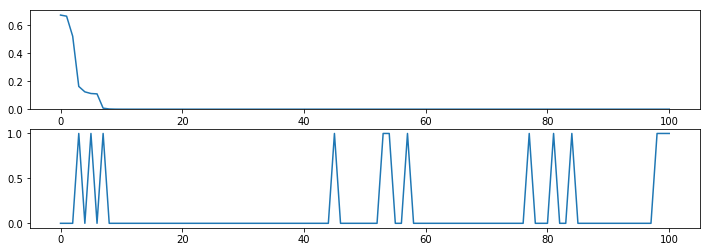

3.6289783865832647e-05 1.554854242702662e-14 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [20]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    z = np.array(np.random.choice(range(len(Theta)), size=len(Theta)//2, replace=False))
    g = np.array([grad(*para) for grad in grads[z]])
    try:
        hg = np.linalg.inv(np.array([[
            h(*para) for h in hy[z]] for hy in hess[z]])) @ g
        para_1[z] = para_1[z] - hg * np.sign(g.T @ hg)
    except:
        para_1[z] = np.full_like(para_1[z], np.nan)
    alpha = (np.cos(np.log(epoch+1e-9) * 2*np.pi)+1)/2 * 3
    for i in range(len(Theta)):
        para_2[i] = para[i] - alpha*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### newton info weighted partial hessian with GD

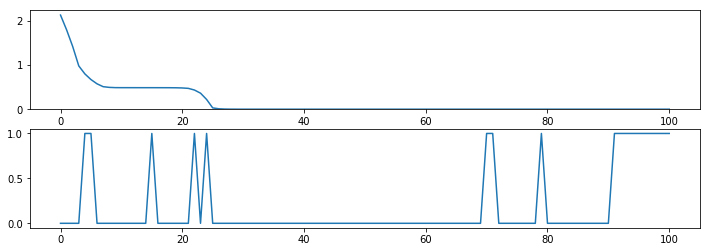

0.00011995461045805543 1.1513437375061774e-06 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [21]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    I = np.array([info(*para) for info in infos])
    I = 1 - (I / np.sum(I))
    I = I / np.sum(I)
    z = np.array(np.random.choice(range(len(Theta)), size=len(Theta)//2, replace=False, p=I))
    g = np.array([grad(*para) for grad in grads[z]])
    try:
        hg = np.linalg.inv(np.array([[
            h(*para) for h in hy[z]] for hy in hess[z]])) @ g
        para_1[z] = para_1[z] - hg * np.sign(g.T @ hg)
    except:
        para_1[z] = np.full_like(para_1[z], np.nan)
    for i in range(len(Theta)):
        para_2[i] = para[i] - 1e-2*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### bb method with GD

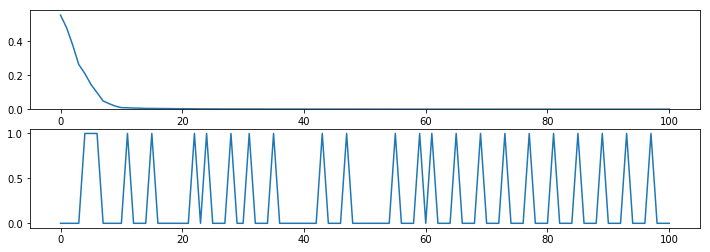

0.00020312160268341203 5.6155563776783254e-05 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [22]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
alpha = 1e-2
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    g = np.array([grad(*para) for grad in grads])
    if epoch > 0:
        g_d = g - g_old
        para_d = para - para_1_old
        alpha = (para_d @ para_d) / (para_d @ g_d)
    g_old = np.copy(g)
    para_1_old = np.copy(para)
    para_1 = para - alpha*g
    for i in range(len(Theta)):
        para_2[i] = para[i] - 1e-2*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### bb method with GD+Moment

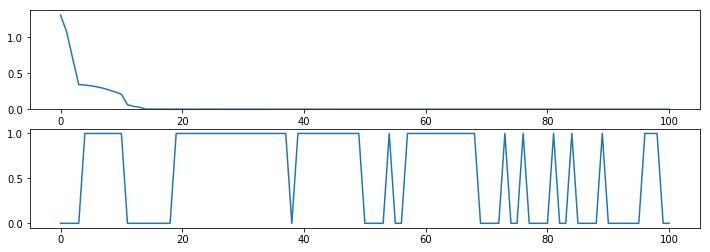

7.792794662370698e-05 1.8336556165029015e-06 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
mnt_old = 0.
beta = 0.9
alpha = 1e-2
for epoch in range(100):
    mnt_1 = np.zeros_like(para)
    mnt_2 = np.zeros_like(para)
    g = np.array([grad(*para) for grad in grads])
    if epoch > 0:
        g_d = g - g_old
        para_d = para - para_1_old
        alpha = (para_d @ para_d) / (para_d @ g_d)
    g_old = np.copy(g)
    para_1_old = np.copy(para)
    mnt_1 = alpha*g
    for i in range(len(Theta)):
        mnt_2[i] = 1e-2*grads[i](*para)
    mnt_2 = beta*mnt_old + (1-beta)*mnt_2
    cost_1 = cost(*(para - mnt_1))
    cost_2 = cost(*(para - mnt_2))
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para -= [mnt_1,mnt_2][cost_lowest]
    mnt_old = mnt_2
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))